In [3]:
!pip install torch-geometric


In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from matplotlib import dates as mdates
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Load your stock prices data
df = pd.read_csv('/content/VCB.csv')
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Convert the data into a graph structure
timestamps = df.index.tolist()
prices = df['Price'].tolist()

<ipython-input-4-90380baac57f>:13: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime


In [5]:
prices

[21552,
 21229,
 21337,
 22468,
 21876,
 21822,
 21822,
 22307,
 21930,
 21768,
 21337,
 21552,
 21606,
 21714,
 21714,
 21445,
 21714,
 21606,
 21768,
 22091,
 22792,
 22522,
 22630,
 22091,
 21930,
 22468,
 22415,
 22522,
 22522,
 22415,
 22307,
 22415,
 22415,
 22468,
 22630,
 23277,
 23007,
 22899,
 23115,
 23330,
 23115,
 22684,
 23061,
 23061,
 22630,
 22684,
 22091,
 22037,
 22037,
 22091,
 22630,
 22468,
 22307,
 22415,
 22684,
 22576,
 22792,
 22899,
 22846,
 23061,
 23115,
 24624,
 24731,
 25432,
 24785,
 24893,
 24785,
 24839,
 25378,
 26186,
 25863,
 26186,
 26402,
 25863,
 25647,
 26025,
 26025,
 26402,
 25917,
 25540,
 24839,
 24731,
 24785,
 24408,
 24408,
 25216,
 25162,
 25270,
 25378,
 25486,
 25755,
 25917,
 25809,
 25917,
 26132,
 26078,
 26025,
 25755,
 25701,
 25378,
 25270,
 25324,
 25216,
 25863,
 25216,
 24893,
 25001,
 25486,
 25486,
 25593,
 26509,
 27210,
 26941,
 27479,
 27479,
 28018,
 29096,
 30982,
 30173,
 29096,
 29904,
 30173,
 29635,
 29904,
 28018,


In [6]:
timestamps

[Timestamp('2016-01-20 00:00:00'),
 Timestamp('2016-01-21 00:00:00'),
 Timestamp('2016-01-22 00:00:00'),
 Timestamp('2016-01-25 00:00:00'),
 Timestamp('2016-01-26 00:00:00'),
 Timestamp('2016-01-27 00:00:00'),
 Timestamp('2016-01-28 00:00:00'),
 Timestamp('2016-01-29 00:00:00'),
 Timestamp('2016-01-02 00:00:00'),
 Timestamp('2016-02-02 00:00:00'),
 Timestamp('2016-03-02 00:00:00'),
 Timestamp('2016-04-02 00:00:00'),
 Timestamp('2016-05-02 00:00:00'),
 Timestamp('2016-02-15 00:00:00'),
 Timestamp('2016-02-16 00:00:00'),
 Timestamp('2016-02-17 00:00:00'),
 Timestamp('2016-02-18 00:00:00'),
 Timestamp('2016-02-19 00:00:00'),
 Timestamp('2016-02-22 00:00:00'),
 Timestamp('2016-02-23 00:00:00'),
 Timestamp('2016-02-24 00:00:00'),
 Timestamp('2016-02-25 00:00:00'),
 Timestamp('2016-02-26 00:00:00'),
 Timestamp('2016-02-29 00:00:00'),
 Timestamp('2016-01-03 00:00:00'),
 Timestamp('2016-02-03 00:00:00'),
 Timestamp('2016-03-03 00:00:00'),
 Timestamp('2016-04-03 00:00:00'),
 Timestamp('2016-07-

In [7]:
# Create edges where each timestamp is connected to the next one
edge_index = torch.tensor([list(range(len(timestamps)-1)), list(range(1, len(timestamps)))], dtype=torch.long)

# Create node features (price at each timestamp)
x = torch.tensor(prices[:-1], dtype=torch.float).view(-1, 1)  # Remove the last element to align with y

# Create a target variable (predict the next day's price)
y = torch.tensor(prices[1:], dtype=torch.float)

# Split the data into training and testing sets (90-10 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)
train_edge_index, test_edge_index = train_test_split(edge_index.t().numpy(), test_size=0.1,shuffle=False, random_state=42)


# Converting back to PyTorch tensors
train_edge_index = torch.tensor(train_edge_index, dtype=torch.long).t()
test_edge_index = torch.tensor(test_edge_index, dtype=torch.long).t()
train_edge_index = train_edge_index[:, :-1]
test_edge_index = test_edge_index[:, :-1]
# Find the minimum index in the edge_index tensor
min_index = test_edge_index.min()

# Shift the indices to start from 0
test_edge_index -= min_index
# Create PyTorch Geometric Data objects for training and testing
train_data = Data(x=x_train, edge_index=train_edge_index, y=y_train)
test_data = Data(x=x_test, edge_index=test_edge_index, y=y_test)


In [8]:
test_data

Data(x=[175, 1], edge_index=[2, 174], y=[175])

In [9]:
dim_h= 64
lr = 0.01
weight_decay = 5e-4
dropout = 0.1


In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,SAGEConv,GATConv
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.datasets import CoraFull
torch.manual_seed(42)
# Define a simple GNN model
class SimpleGNN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = nn.Linear(num_features, hidden_size)
        self.conv2 = nn.Linear(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        return x
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    def forward(self, data):
        h = self.gcn1(data.x, data.edge_index)
        h = torch.relu(h)
        out = self.gcn2(h, data.edge_index)
        return out
class SAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    def forward(self, data):
        h = self.sage1(data.x, data.edge_index)
        h = torch.relu(h)
        h = self.sage2(h,data.edge_index)
        return h
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, num_heads):
        super(GAT, self).__init__()
        self.gat1 = GATConv(dim_in, dim_h, heads=num_heads)
        self.gat2 = GATConv(dim_h * num_heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
    def forward(self,data):
        h = self.gat1(data,x, data.edge_index)
        h = torch.relu(h)
        out = self.gat2(h, data.edge_index)
        return out
# Instantiate the GNN model, loss function, and optimizer
model = SAGE(1,16,1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the GNN on the training data
num_epochs = 300
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, train_data.y.view(-1, 1))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')



Epoch 1/300, Loss: 4783267840.0
Epoch 2/300, Loss: 4181264384.0
Epoch 3/300, Loss: 3626808064.0
Epoch 4/300, Loss: 3119585536.0
Epoch 5/300, Loss: 2658299904.0
Epoch 6/300, Loss: 2240601856.0
Epoch 7/300, Loss: 1863797632.0
Epoch 8/300, Loss: 1525193856.0
Epoch 9/300, Loss: 1222395008.0
Epoch 10/300, Loss: 953580992.0
Epoch 11/300, Loss: 717696064.0
Epoch 12/300, Loss: 514489792.0
Epoch 13/300, Loss: 344375552.0
Epoch 14/300, Loss: 208105008.0
Epoch 15/300, Loss: 106381560.0
Epoch 16/300, Loss: 39176528.0
Epoch 17/300, Loss: 5655575.5
Epoch 18/300, Loss: 6202279.0
Epoch 19/300, Loss: 33228068.0
Epoch 20/300, Loss: 71088768.0
Epoch 21/300, Loss: 110215576.0
Epoch 22/300, Loss: 146401728.0
Epoch 23/300, Loss: 174365616.0
Epoch 24/300, Loss: 188339984.0
Epoch 25/300, Loss: 187109104.0
Epoch 26/300, Loss: 172526656.0
Epoch 27/300, Loss: 148266368.0
Epoch 28/300, Loss: 118685424.0
Epoch 29/300, Loss: 87975408.0
Epoch 30/300, Loss: 59601532.0
Epoch 31/300, Loss: 36004212.0
Epoch 32/300, Loss

In [11]:
# Evaluate the model on the testing data
model.eval()
with torch.no_grad():
    test_predictions = model(test_data)

# Convert torch tensors to numpy arrays for plotting
x_train_np = x_train.numpy().flatten()
y_train_np = y_train.numpy()

x_test_np = x_test.numpy().flatten()
y_test_np = y_test.numpy()
test_predictions_np = test_predictions.numpy().flatten()


In [12]:
# Tính MAE cho testing
mae_test = mean_absolute_error(y_test_np, test_predictions_np)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test_np, test_predictions_np)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test_np, test_predictions_np, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test_np,test_predictions_np, squared=False)
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('----------------------')


---------TEST----------
MAPE: 1.55
MAE: 1186.66
RMSE: 1906.457
MSLE: 0.024
----------------------


In [13]:
test_data

Data(x=[175, 1], edge_index=[2, 174], y=[175])

In [14]:
test_preddict=test_data

In [15]:
test_preddict

Data(x=[175, 1], edge_index=[2, 174], y=[175])

In [16]:
# Use the trained GNN model to make predictions for the next 30 days
model.eval()
future_x=[]
t=173
with torch.no_grad():
    for i in range(30):
        future_prediction = model(test_preddict)
        future_x.append(future_prediction[-1])
        new_edge = torch.tensor([[t+1], [t+2]], dtype=torch.long)
        test_preddict.x= torch.cat([test_preddict.x, future_prediction[-1].reshape(1,-1)])
        prices.append(future_prediction[-1])
        test_preddict.edge_index = torch.cat([test_preddict.edge_index, new_edge], dim=1)
        t+=1


In [17]:
future_x

[tensor([89962.2344]),
 tensor([89951.6562]),
 tensor([89954.8125]),
 tensor([89957.4922]),
 tensor([89959.8750]),
 tensor([89962.2734]),
 tensor([89964.6797]),
 tensor([89967.0781]),
 tensor([89969.4844]),
 tensor([89971.8828]),
 tensor([89974.2812]),
 tensor([89976.6875]),
 tensor([89979.0859]),
 tensor([89981.4844]),
 tensor([89983.8906]),
 tensor([89986.2969]),
 tensor([89988.7031]),
 tensor([89991.1094]),
 tensor([89993.5156]),
 tensor([89995.9141]),
 tensor([89998.3125]),
 tensor([90000.7109]),
 tensor([90003.1172]),
 tensor([90005.5156]),
 tensor([90007.9219]),
 tensor([90010.3281]),
 tensor([90012.7266]),
 tensor([90015.1250]),
 tensor([90017.5312]),
 tensor([90019.9375])]

In [18]:
future_timestamps = pd.date_range(start=timestamps[-1], periods=30, freq='B')  # Assuming business days


In [19]:
future_timestamps_np = mdates.date2num(future_timestamps)
future_prices_np = torch.tensor(future_x, dtype=torch.float).numpy()

In [20]:
prices

[21552,
 21229,
 21337,
 22468,
 21876,
 21822,
 21822,
 22307,
 21930,
 21768,
 21337,
 21552,
 21606,
 21714,
 21714,
 21445,
 21714,
 21606,
 21768,
 22091,
 22792,
 22522,
 22630,
 22091,
 21930,
 22468,
 22415,
 22522,
 22522,
 22415,
 22307,
 22415,
 22415,
 22468,
 22630,
 23277,
 23007,
 22899,
 23115,
 23330,
 23115,
 22684,
 23061,
 23061,
 22630,
 22684,
 22091,
 22037,
 22037,
 22091,
 22630,
 22468,
 22307,
 22415,
 22684,
 22576,
 22792,
 22899,
 22846,
 23061,
 23115,
 24624,
 24731,
 25432,
 24785,
 24893,
 24785,
 24839,
 25378,
 26186,
 25863,
 26186,
 26402,
 25863,
 25647,
 26025,
 26025,
 26402,
 25917,
 25540,
 24839,
 24731,
 24785,
 24408,
 24408,
 25216,
 25162,
 25270,
 25378,
 25486,
 25755,
 25917,
 25809,
 25917,
 26132,
 26078,
 26025,
 25755,
 25701,
 25378,
 25270,
 25324,
 25216,
 25863,
 25216,
 24893,
 25001,
 25486,
 25486,
 25593,
 26509,
 27210,
 26941,
 27479,
 27479,
 28018,
 29096,
 30982,
 30173,
 29096,
 29904,
 30173,
 29635,
 29904,
 28018,


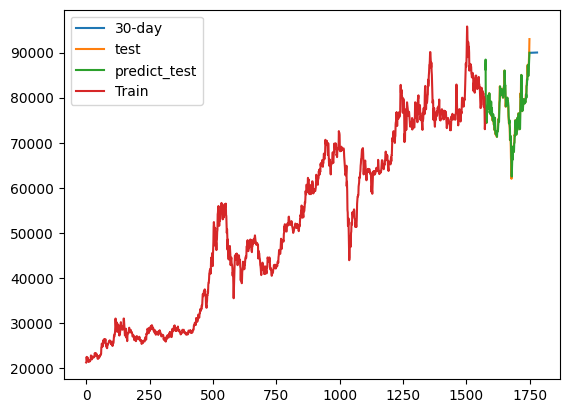

In [22]:
predict_data_index = pd.RangeIndex(start=1750, stop=1780, step=1)
plt.plot(predict_data_index, future_x, label='30-day')
test_data_index = pd.RangeIndex(start=1575, stop=1750, step=1)
plt.plot(test_data_index, y_test_np, label='test')
test_data_index = pd.RangeIndex(start=1575, stop=1750, step=1)
plt.plot(test_data_index, test_predictions_np, label='predict_test')
train_data_index = pd.RangeIndex(start=0, stop=1575, step=1)
plt.plot(train_data_index, y_train_np, label='Train')
plt.legend()
plt.show()